In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer,AutoConfig,AutoModel,Trainer
from tqdm import tqdm,trange,tqdm_notebook
from tqdm.notebook import tqdm as notetqdm
from torch.autograd import Variable
from transformers import TrainingArguments
import random

In [2]:
MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'
LOG_DIR = "./news-classification"
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 30
LEARN_RATE = 5e-6
MAX_CATE_SIZE = 6000

In [3]:
def load_data(path,type='JSON'):
    if type == 'JSON':
        df = pd.read_json(path)
    else:
        df = pd.read_csv(path)
    labels = df['category'].tolist()
    heads = df['headline'].tolist()
    descriptions = df['description'].tolist()
    contents = [h+d for h,d in zip(heads,descriptions)]
    label_dic = {}
    label_count = {}
    
    # itos                                        
    label_set = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING', 
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION', 
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT', 
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA', 
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY', 
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']
    
    # stoi
    for idx,label in enumerate(label_set):
        label_dic[label] = idx
   

    flitered_labels = []
    flitered_contents = []
    for cate,cont in zip(labels,contents):
        if cate not in label_count.keys():
            label_count[cate] = 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
        elif label_count[cate] < MAX_CATE_SIZE:
            label_count[cate] +=1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
        
    # for idx,key in enumerate(label_set):
    #     print(idx, ' ', label_count[key])
    # print(len(label_count.keys()))
    
    # shuffle
    idx_list = list(range(0,len(flitered_labels),1))
    random.shuffle(idx_list)

    labels = []
    contents = []
    for idp in idx_list:
        labels.append(flitered_labels[idp])
        contents.append(flitered_contents[idp])
        

        
    print('Data loaded: ',len(flitered_labels), len(flitered_contents))
    return labels, contents,label_set,label_dic

In [4]:
labels,contents,lset,ldic = load_data('data/cleaned_es_data.json')

Data loaded:  92131 92131


In [5]:
def pre_encode_dic(model_name,contents,max_length=512):
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    except OSError:
        print('OSError! can not load tokenizer!')
    else:
        print('Tokenizer loaded...')
        return tokenizer(contents,
                         add_special_tokens=True,
                         padding=True,
                         max_length=max_length,
                         truncation=True,
                         return_tensors='pt')

In [6]:
def pre_encode_list(model_name,contents,max_length=512):
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    except OSError:
        print('OSError! can not load tokenizer!')
    else:
        print('Tokenizer loaded...')
        res = []
        for content in tqdm(contents):
            res.append(tokenizer(content,
                                 add_special_tokens=True,
                                 padding='max_length',
                                 max_length=max_length,
                                 truncation=True,
                                 return_tensors='pt'))
        return res

In [7]:
import time
# encode 1 87s
start = time.time()
encodings_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print(time.time()-start)

# start = time.time()
# encodings_dic = pre_encode_dic(MODEL_NAME,contents,MAX_SEQ_LENGTH)
# print(time.time()-start)

  0%|▎                                                                           | 313/92131 [00:00<00:59, 1553.33it/s]

Tokenizer loaded...


100%|██████████████████████████████████████████████████████████████████████████| 92131/92131 [00:59<00:00, 1552.17it/s]

62.70980381965637


In [8]:
class NewsCategoryDataset(Dataset):
    def __init__(self, 
                 labels,inputs,origins,label_dic,
                 mode='train',
                 balance=[0.85,0.15]):
        train_num = int(len(labels)*balance[0])
        val_num = int(len(labels)*balance[1])
        #choose mode
        self.label_dic = label_dic
        if mode == 'train':
            self.inputs = inputs[:train_num]
            self.origins = origins[:train_num]
            self.labels = labels[:train_num]
        elif mode == 'val':
            self.inputs = inputs[-val_num:]
            self.origins = origins[-val_num:]
            self.labels = labels[-val_num:]
        '''
            elif mode == 'test':
            self.inputs = inputs[-test_num:]
            self.origins = origins[-test_num:]
            self.labels = labels[-test_num:]

        '''
                
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,idx):

        y = self.labels[idx]
        y_encoded = torch.Tensor([self.label_dic.get(y, -1)]).long().squeeze(0)
        res = {'input_ids':self.inputs[idx]['input_ids'][0],
               'attention_mask':self.inputs[idx]['attention_mask'][0],
              'origin_contents':self.origins[idx],
              'targets':y_encoded}
        return res

In [9]:
train_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic)
print(len(train_dataset))
valid_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic, 'val')
print(len(valid_dataset))

78311
13819


In [10]:
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=False)    
}

In [11]:
class BertForSequenceClassification(nn.Module):
    def __init__(self,model_name,num_classes=None):
        super().__init__()
        config = AutoConfig.from_pretrained(model_name,num_labels=num_classes)

        self.bert = AutoModel.from_pretrained(model_name,config=config)
        self.MLP =nn.Linear(config.hidden_size,num_classes)
        
    def forward(self,features,attention_mask=None,head_mask=None):
        
        assert attention_mask is not None,'attention_mask is none'
        bert_output = self.bert(input_ids=features,
                               attention_mask=attention_mask,
                               head_mask=head_mask)
    
        hidden_state = bert_output[0]

        pool_output = hidden_state[:,0]
        # print(pool_output)
        # print(pool_output.shape)
        logits = self.MLP(pool_output)
        #logits.unsqueeze(1)
        return logits

def weight_init(m):
    if isinstance(m,nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias,0)

## Train

In [12]:
model = BertForSequenceClassification(MODEL_NAME,len(lset))
model.apply(weight_init)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()
    criterion

In [13]:
def train_classifier(model,epoch,iterator,loss,optimizer=None,
                     scheduler=None
                    ):
    loss = 0
    tokens = 0
    accs = []
    losses = []
    epoch_losses = []
    epoch_accs = []
    for i in range(epoch):
        print('epoch {}'.format(i))
        model.train() 
        for batch,data in enumerate(notetqdm(iterator['train'])):
            optimizer.zero_grad()
            features = data['input_ids'].cuda()
            #print(features.shape)
            att_mask = data['attention_mask'].cuda()
            y = data['targets'].cuda()
            
            #print(y.shape)
            
            y_pred = model(features,att_mask)
            
            # print(y_pred.shape)
            

            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()

            # print('---------------------------------')
            
            # print('---------------------------------')

            y = y.cpu().numpy()
            # print('target: ',y)
            
            y_pred = y_pred.cpu().detach().numpy()
            ss = np.argmax(y_pred, axis=1)
            ss = ss.tolist()
            '''
            # print screen
            for i in range(len(data)):
                print(data['origin_contents'][i])
                print('pred: ',lset[ss[i]])
                print('true: ',lset[y[i]])
                print('--------------')
            '''
            acc = (ss == y).sum().item()/len(y)
            accs.append(acc)
            losses.append(loss.item())
            print('Epoch {} batch {}, loss: {:.4} acc: {:.6} '.format(i,batch, loss , acc*100), end='\r')
        epoch_losses.append(np.mean(np.array(losses)))
        epoch_accs.append(np.mean(np.array(accs)))
        print()
        # vaild
        print('validating...')
        true_labels = []
        pred_outputs = []
        model.eval()
        with torch.no_grad():
            for ba,data in enumerate(iterator['valid']):
                features = data['input_ids'].to('cuda')
                att_mask = data['attention_mask'].to('cuda')
                targets = data['targets']
                targets.numpy()
                true_labels += targets.tolist()
                outputs = model(features,att_mask)
                outputs = outputs.cpu().detach().numpy()
                outputs = np.argmax(outputs,axis=1)
                pred_outputs += outputs.tolist()
                '''
                # print screen
                for i in range(len(data)):
                    print(data['origin_contents'][i])
                    print('pred: ',lset[outputs[i]])
                    print('true: ',lset[targets[i]])
                    print('--------------')
                '''
                
            valid_acc = sum([1 if y==p else 0 for y,p in zip(pred_outputs,true_labels)])/len(true_labels)
            print('After Epoch {} , valid acc: {}, avg loss{}  avg acc{}'.format(i,valid_acc,epoch_losses[-1],epoch_accs[-1]))
        if scheduler is not None:
            scheduler.step(loss)
        torch.save(model.module.state_dict(),'./results//12-16-epoch-{}.pth'.format(i))
        # torch.cuda.empty_cache()
    return accs,losses
     

In [14]:
acclist,losslist = train_classifier(model,6,train_val_loaders,criterion,optimizer,scheduler)

epoch 0


Epoch 0 batch 2610, loss: 1.622 acc: 45.4545  

validating...
After Epoch 0 , valid acc: 0.5844851291699834, avg loss1.8461632068154457  avg acc0.46188735304016804
epoch 1


Epoch 1 batch 2610, loss: 1.537 acc: 36.3636  

validating...
After Epoch 1 , valid acc: 0.6164700774296259, avg loss1.603285925306611  avg acc0.5306175504566926
epoch 2


Epoch 2 batch 2610, loss: 1.321 acc: 63.6364  

validating...
After Epoch 2 , valid acc: 0.6378174976481655, avg loss1.4672930704501796  avg acc0.568529028314551
epoch 3


Epoch 3 batch 2610, loss: 0.7951 acc: 54.5455 

validating...
After Epoch 3 , valid acc: 0.6535928793689847, avg loss1.3697939850033265  avg acc0.5952540533639729
epoch 4


Epoch 4 batch 2610, loss: 0.9591 acc: 81.8182 

validating...
After Epoch 4 , valid acc: 0.656270352413344, avg loss1.2904331248571752  avg acc0.6170395645462668
epoch 5


Epoch 5 batch 2610, loss: 0.7153 acc: 90.9091 

validating...
After Epoch 5 , valid acc: 0.6588754613213691, avg loss1.2221613831529896  avg acc0.635716026600745


## Check Acc and Loss

In [84]:
batch_step = 50
new_acc = acclist[0::batch_step]
new_loss = losslist[0::batch_step]

In [85]:
import matplotlib.pyplot as plt

In [90]:
x_label = [i*batch_step for i in range(len(new_acc))]
new_acc = [np.mean(np.array(acclist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_acc))]
loss_acc = [np.mean(np.array(losslist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_loss))]

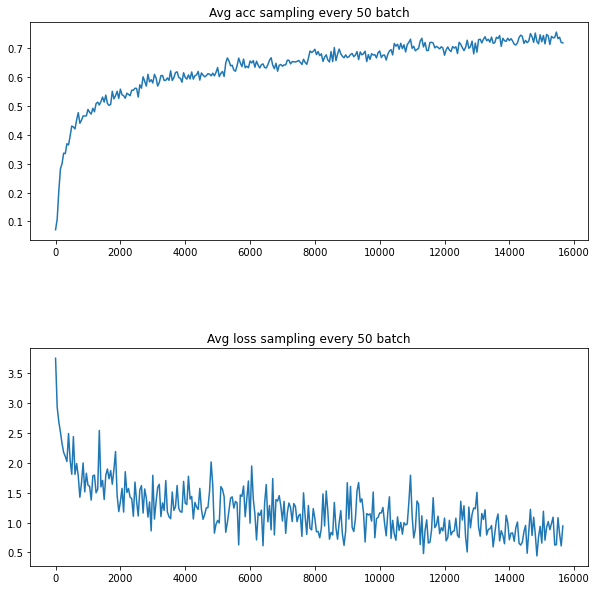

In [92]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1,)
ax1.plot(x_label,new_acc)
ax1.set_title('Avg acc sampling every {} batch'.format(batch_step))
ax2 = plt.subplot(2,1,2,sharex=ax1)
ax2.plot(x_label,new_loss)
ax2.set_title('Avg loss sampling every {} batch'.format(batch_step))
plt.subplots_adjust(wspace =0, hspace =0.5)
plt.show()

## Visualization

In [93]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
model = BertForSequenceClassification(MODEL_NAME,len(lset))
state_dict = torch.load('./results/lr3e-5/12-15-epoch-5.pth')
model.cuda()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [110]:
iterator = train_val_loaders
true_labels = []
pred_outputs = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator['valid'])):
        
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].to('cuda')
        targets = data['targets']
        targets.numpy()
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs,axis=1)
        '''
        # print screen 
        for i in range(len(data)):
            print(data['origin_contents'][i])
            print('pred: ',lset[outputs[i]])
            print('true: ',lset[targets[i]])
            print('--------------')
        
        '''
        
        pred_outputs += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_outputs))
    print(pred_outputs[:15])


13819
[23, 0, 0, 8, 17, 14, 3, 23, 14, 7, 11, 20, 2, 8, 7]
13819
[23, 0, 0, 8, 17, 14, 3, 23, 14, 7, 11, 20, 2, 8, 7]


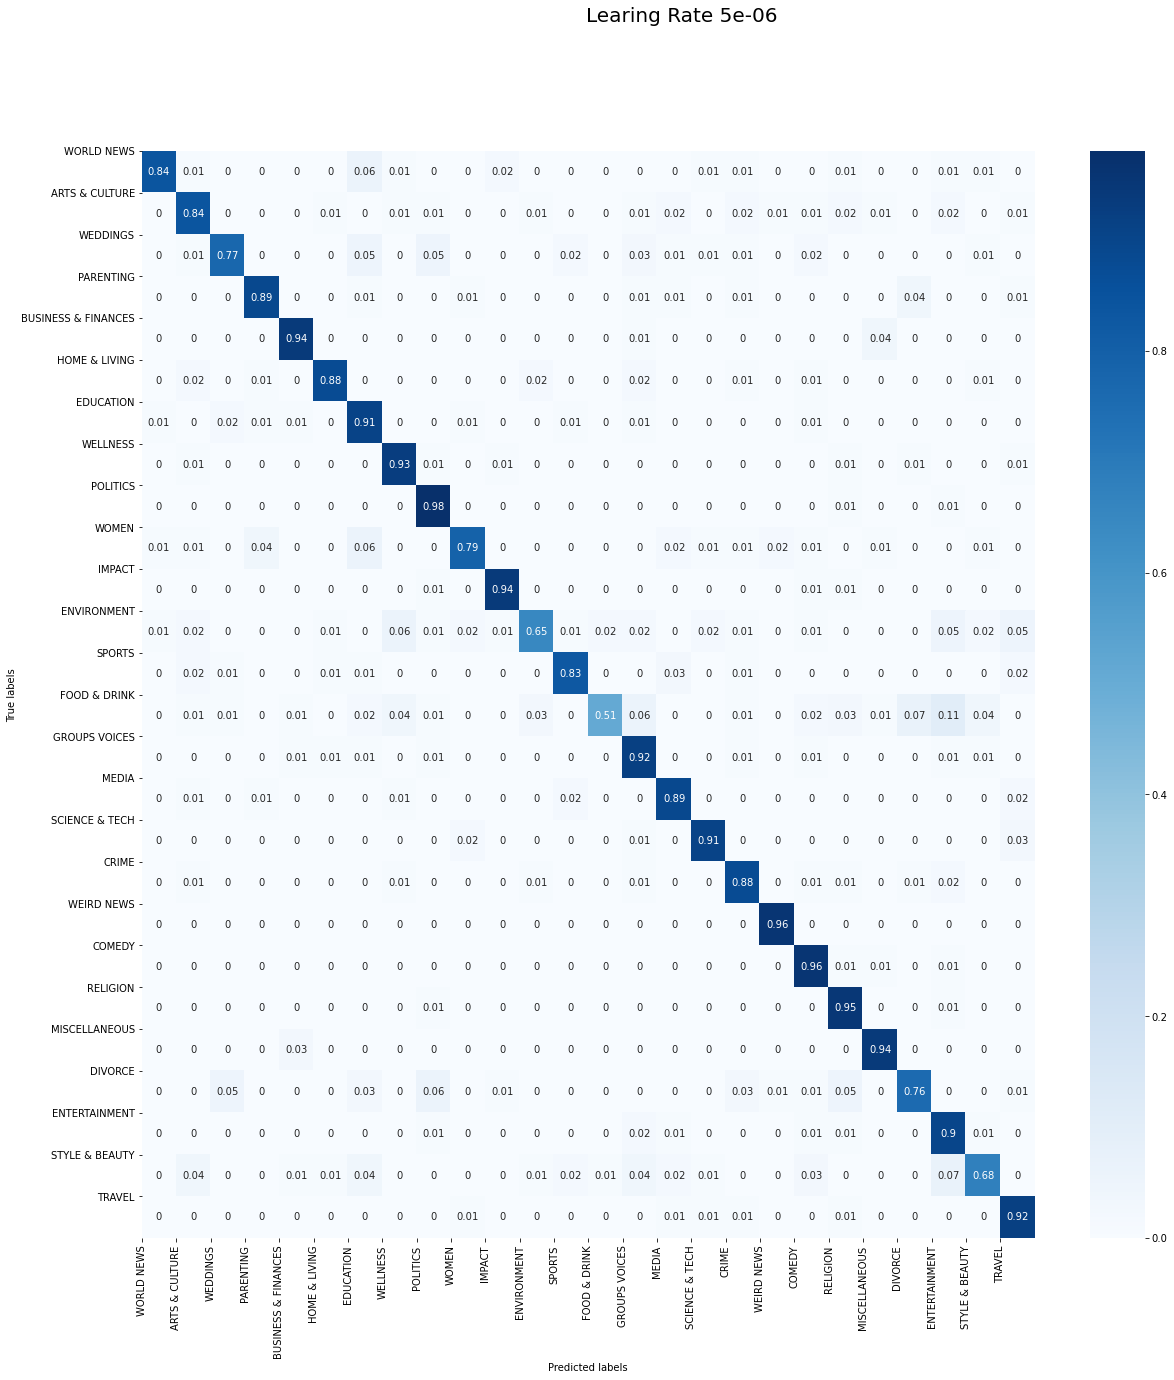

In [111]:
lset = list(lset)
true_cate = [lset[i] for i in true_labels]
pred_cate = [lset[j] for j in pred_outputs]
# print(true_cate[:20])
# print(pred_cate[:20])
con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)

# === plot ===
fig = plt.figure(figsize=(20, 20))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
catee = list(range(0,len(lset),1))
fig.suptitle('Learing Rate '+str(LEARN_RATE),fontsize=20)
plt.xlabel('Predicted labels')
plt.xticks(catee,lset)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catee,lset)
plt.yticks(rotation=360)
plt.show()

## Transformers Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,
    label_names=['label']
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset
)

In [ ]:
a = torch.Tensor([[0,0,1],
                  [1,0,0]])
print(a.shape)
b = torch.Tensor([2,0]).long()
print(b.shape)
print(criterion(a,b))

In [ ]:
for data in train_val_loaders['valid']:
    print('label:',data['targets'].tolist())

In [15]:
torch.save(model.module.state_dict(),'./results/12-12module.pth')

In [17]:
state_dict

OrderedDict([('module.bert.embeddings.position_ids',
              tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
                        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
                        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
                        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
                        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
                        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
                        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
                        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
                       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
                       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
                 

## Check

In [5]:
for i in range(10):
    print('----------------')
    print(labels[i])
    print(contents[i])

----------------
WORLD NEWS
El nuevo Director General de la OMS debe dar prioridad a los trabajadores sanitarios comunitariosPor Carl Manlan En 1978, se firmó la Declaración de Alma-Ata con el ambicioso objetivo de lograr "La salud para todos en el año 2000"
----------------
MEDIA
Donald Trump ha traído la lucha por la libertad de prensa"Como profesión, luchemos por lo que es correcto", dijo Christiane Amanpour de CNN. "Luchemos por nuestros valores".
----------------
GROUPS VOICES
LeBron James tiene la mejor respuesta al anuncio racista en línea de H&M"¡Nos malinterpretamos a todos! ¡Y no vamos a hacerlo! ¡Derecha!"
----------------
SCIENCE & TECH
Sí, puedes alquilar tu bastón ocular por dineroEn noviembre de 1954, Sammy Davis Jr., de 29 años, estaba conduciendo a Hollywood cuando un accidente de coche dejó su ojo roto más allá de las reparaciones
----------------
ENVIRONMENT
Corte: La ley ambiental clave no se aplica a parte de Enbridge Keystone XL "Clone"Un tribunal de distrito de E

In [16]:
for i in range(1,10,1):
    data = train_dataset[i]
    print(data['origin_contents'])
    print(lset[data['targets'].numpy().tolist()])

Donald Trump ha traído la lucha por la libertad de prensa"Como profesión, luchemos por lo que es correcto", dijo Christiane Amanpour de CNN. "Luchemos por nuestros valores".
MEDIA
LeBron James tiene la mejor respuesta al anuncio racista en línea de H&M"¡Nos malinterpretamos a todos! ¡Y no vamos a hacerlo! ¡Derecha!"
GROUPS VOICES
Sí, puedes alquilar tu bastón ocular por dineroEn noviembre de 1954, Sammy Davis Jr., de 29 años, estaba conduciendo a Hollywood cuando un accidente de coche dejó su ojo roto más allá de las reparaciones
SCIENCE & TECH
Corte: La ley ambiental clave no se aplica a parte de Enbridge Keystone XL "Clone"Un tribunal de distrito de EE.UU. para el Distrito de Columbia ha dictaminado que el Flanagan South Pipeline de 600 millas de largo de Enbridge, un "clone" de Keystone XL, está autorizado legalmente para iniciar la apertura de negocios en octubre.
ENVIRONMENT
Formas creativas de ahorrar en una boda: Aprender chalecoCuando les mostramos cómo Abigail Dalton planeó su

In [18]:
for i,data in enumerate(train_val_loaders['valid']):
    print(data['origin_contents'][0])
    label = lset[data['targets'][0].numpy().tolist()]
    print(label)
    print('----------------')

La conversación imposible: hablar con los niños sobre la islamofobiaIntenté empezar una conversación con él, pero rápidamente me di cuenta de que no iba a ir a ninguna parte.
PARENTING
----------------
Una cosa más que no comeré (y por qué)Bueno, está casi extinguido gracias al insaciable apetito humano por sushi. ¿Miedo a los tiburones? No hay problema, hemos matado a casi todos ellos.
ENVIRONMENT
----------------
Hablando con los niños para que escuchenNos hemos convertido en esos padres que ya están molestos antes de que suceda algo molesto. Que usan el tiempo como muletas, entregándolos de la mañana a la noche. Estamos dejando que el poder lucha con un niño pequeño quite nuestro poder como padres.
PARENTING
----------------
El reportero de los '60 minutos' revela la razón refrigerante de Trump para aplastar a la prensaLesley Stahl dijo que Trump admitió que ataca a periodistas por lo que "Nadie los creerá".
MEDIA
----------------
El sexismo de los padres puede curvar las ambiciones

Un número impactante de padres mantienen las opioides sobrantes de sus hijos"Esta es una oportunidad perdida para prevenir el uso indebido de medicamentos recetados entre los niños".
WELLNESS
----------------
Recordando la masacre en la rodilla heridaCincuenta y un años antes de que la fuerza de ataque japonesa lanzara sus bombas mortales en Pearl Harbor, ocurrió otro "Día de la Infamia" que vivirá para siempre en la mente del pueblo Lakota (Sioux).
MEDIA
----------------
Servidor embarazada recibe una propina de $900 justo a tiempo para la Navidad"Siempre escuchas acerca de estas [cosas] sucediendo, pero nunca esperas ser el receptor de ello."
MISCELLANEOUS
----------------
Discursos de Oscar: ¿Qué ganadores del Oscar agradecieron a sus cónyuges en el escenario?Ganar un Oscar no es una pequeña hazaña, y a menudo puede dejar estrellas perfectamente aturdidas y sin palabras en el escenario.
WEDDINGS
----------------
Un policía se enfrenta a cargos de violación en serie, pero sus 13 acus

Jimmy Kimmel desgarra a Trump por hacer "peor que nada" para detener la violencia armada"Si no estás de acuerdo que tenemos que hacer algo al respecto, obviamente estás mentalmente enfermo".
COMEDY
----------------
Mejores citas de estilo: Gwen Stefani, Lauren Hutton, Lady Gaga y más sobre el maquillajeMuchas estrellas recogen consejos de belleza mientras están en el set de una película, en una sesión de fotos o mientras viajan, por lo que no es sorpresa que estén
STYLE & BEAUTY
----------------
Nueva lista de chequeo de vuelta a la escuela Artículo en California: Inscribirse en la cobertura de saludAquí en California, es nuestro objetivo inscribir aún más familias mientras miramos hacia adelante para el nuevo período de inscripción abierto a partir del 15 de noviembre de 2014.
IMPACT
----------------
El profesor renuncia después de enviar una carta anti-gay sorprendentemente a un periódico estudiantilMichael Stack citó un pasaje bíblico que afirmaba que los gays "recibían morir".
GROU